Imports

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import cv2
import random
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score

2025-01-22 00:10:10.179283: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 00:10:10.471870: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 00:10:10.471920: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 00:10:10.472916: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 00:10:10.604486: I tensorflow/core/platform/cpu_feature_g

In [2]:
from keras.models import load_model

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [4]:
# 2. Directory Setup
os.makedirs('./models/', exist_ok=True)
os.makedirs('./plots/loss/', exist_ok=True)
os.makedirs('./plots/accuracy/', exist_ok=True)
os.makedirs('./logs/', exist_ok=True)  # For TensorBoard logs

In [5]:
import tensorflow_model_optimization as tfmot

In [ ]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

In [7]:
model = Sequential(name = "MobileNet_E_New")

In [8]:
tf.compat.v1.reset_default_graph()

In [9]:
root_data_dir = "./Dataset"
img_width, img_height = 128, 128

In [10]:
def apply_gaussian_noise(x, mean=0, std=0.1):
    noise = np.random.normal(mean, std, x.shape)
    noisy_x = x + noise
    return np.clip(noisy_x, 0, 255)

def apply_color_channel_changes(x, delta_hue=10, delta_saturation=0.2, delta_brightness=0.2):
    x = np.uint8(x)  
    hsv_x = cv2.cvtColor(x, cv2.COLOR_RGB2HSV)
    
    h, s, v = cv2.split(hsv_x)
    h = (h + delta_hue) % 180
    s = np.clip(s + delta_saturation, 0, 255)
    v = np.clip(v + delta_brightness, 0, 255)
    
    h = h.astype(np.uint8)
    s = s.astype(np.uint8)
    v = v.astype(np.uint8)
    
    hsv_augmented = cv2.merge((h, s, v))
    augmented_x = cv2.cvtColor(hsv_augmented, cv2.COLOR_HSV2RGB)
    
    return augmented_x

def apply_random_crop(x, crop_size=(120, 120)):
    h, w, _ = x.shape
    
    if h < crop_size[0] or w < crop_size[1]:
        raise ValueError("Crop size is larger than image dimensions")
    
    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])
    
    cropped_x = x[top:top + crop_size[0], left:left + crop_size[1], :]
    
    resized_cropped_x = cv2.resize(cropped_x, (img_width, img_height))
    
    return resized_cropped_x

In [11]:
class CustomImageDataGenerator(ImageDataGenerator):
    def standardize(self, x):
        x = apply_gaussian_noise(x)
        x = apply_color_channel_changes(x)
        x = apply_random_crop(x)
        x = tf.keras.applications.mobilenet.preprocess_input(x)
        return x

train_datagen = CustomImageDataGenerator(
    channel_shift_range=0.1,
)

test_datagen = CustomImageDataGenerator()

class_subdirs = os.listdir(root_data_dir)
num_classes = len(class_subdirs)

num_samples_per_class = [len(os.listdir(os.path.join(root_data_dir, class_name))) for class_name in class_subdirs]

num_samples = sum(num_samples_per_class)
fold_histories = []
fold_f1_scores = []

def create_image_dataframe(root_data_dir):
    data = []
    for class_name in os.listdir(root_data_dir):
        class_dir = os.path.join(root_data_dir, class_name)
        for image_name in os.listdir(class_dir):
            data.append({'file_path': os.path.join(class_dir, image_name), 'label': class_name})
    return pd.DataFrame(data)
    
image_dataframe = create_image_dataframe(root_data_dir)

In [12]:
#using functional API

In [13]:
# 1. Define the Input layer
input_layer = Input(shape=(img_width, img_height, 3))


# 2. Load the pre-trained MobileNetV2 model without the top classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer, input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = True  # Make backbone trainable

# 4. Add custom layers on top of the base_model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Removed activation from here
x = BatchNormalization()(x)
x = Activation('relu')(x)  # Added Activation layer separately
x = Dropout(0.65)(x)
output_layer = Dense(num_classes, activation='softmax')(x)



# 5. Create the Functional API model
full_model = Model(inputs=input_layer, outputs=output_layer)

# 6. Compile the model with the SGD optimizer
opt = SGD(learning_rate=0.01)
full_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [14]:
# Optional: Display the model architecture
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

# Normal model, no QAT

In [15]:
# Initialize variables to track the best fold
best_fold_idx = -1
best_accuracy = -1
best_test_data = None

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
fold_accuracies = []
fold_f1_scores = []



In [17]:
for fold_idx, (train_index, test_index) in enumerate(kfold.split(image_dataframe)):
    print(f"Training fold {fold_idx + 1}/{num_folds}")

    train_data = image_dataframe.iloc[train_index]
    test_data = image_dataframe.iloc[test_index]

    # Data Generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='file_path',
        y_col='label',
        target_size=(img_width, img_height),
        batch_size=32,  # Increased batch size
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col='file_path',
        y_col='label',
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )


    # 1. Define the Input layer
    input_layer = Input(shape=(img_width, img_height, 3))
    
    # 2. Load the pre-trained MobileNetV2 model without the top classification layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer, input_shape=(img_width, img_height, 3))
    
    # Set all layers in the base model to trainable
    base_model.trainable = True
    
    # 4. Add custom layers on top of the base_model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Removed activation from here
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  # Added Activation layer separately
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    # 5. Create the Functional API model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # 6. Compile the model with the SGD optimizer
    opt = SGD(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # 7. Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        # ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
        ModelCheckpoint(
            filepath=f'./models/best_model_fold_{fold_idx + 1}.h5',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        TensorBoard(log_dir=f'./logs/fold_{fold_idx + 1}')
    ]

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=100,
        validation_data=test_generator,
        callbacks=callbacks
    )
    
       # 9. Evaluation
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    accuracy = history.history['val_accuracy'][-1]
    fold_accuracies.append(accuracy)
    print(f"Fold {fold_idx + 1} Validation Accuracy: {accuracy:.4f}")

    f1 = f1_score(y_true, y_pred, average='weighted')
    fold_f1_scores.append(f1)
    print(f"Fold {fold_idx + 1} Validation F1 Score: {f1:.4f}")

    # 10. Plot and Save Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - Fold {fold_idx + 1}')
    plt.legend()
    loss_curve_path = f'./plots/loss/MNV2_loss_curve_fold_{fold_idx + 1}.png'
    plt.savefig(loss_curve_path)
    plt.close()

    # 11. Plot and Save Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - Fold {fold_idx + 1}')
    plt.legend()
    accuracy_curve_path = f'./plots/accuracy/MNV2_accuracy_curve_fold_{fold_idx + 1}.png'
    plt.savefig(accuracy_curve_path)
    plt.close()

    # 12. Track the Best Fold
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold_idx = fold_idx
        best_test_data = test_data.copy()
        best_model_path = f'./models/best_overall_model_fold_{fold_idx + 1}.h5'
        model.save(best_model_path)
        print(f"New best model saved for fold {fold_idx + 1} with accuracy {accuracy:.4f}")

# 13. Final Evaluation Across Folds
avg_accuracy = np.mean(fold_accuracies)
avg_f1 = np.mean(fold_f1_scores)
print(f"\nAverage Validation Accuracy across all folds: {avg_accuracy:.4f}")
print(f"Average Validation F1 Score across all folds: {avg_f1:.4f}")

print(f"\nBest Fold: {best_fold_idx + 1} with Validation Accuracy: {best_accuracy:.4f}")

Training fold 1/5
Found 1578 validated image filenames belonging to 3 classes.
Found 395 validated image filenames belonging to 3 classes.


Epoch 1/100
48/49 [============================>.] - ETA: 0s - loss: 3.0482 - accuracy: 0.7077
Epoch 1: val_accuracy improved from -inf to 0.57722, saving model to ./models/best_model_fold_1.h5


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 17s 198ms/step - loss: 3.0467 - accuracy: 0.7070 - val_loss: 3.5961 - val_accuracy: 0.5772
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 2.6240 - accuracy: 0.8810
Epoch 2: val_accuracy did not improve from 0.57722
49/49 [==============================] - 8s 164ms/step - loss: 2.6240 - accuracy: 0.8810 - val_loss: 3.5961 - val_accuracy: 0.5165
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 2.4883 - accuracy: 0.9166
Epoch 3: val_accuracy improved from 0.57722 to 0.59494, saving model to ./models/best_model_fold_1.h5
49/49 [==============================] - 8s 172ms/step - loss: 2.4883 - accuracy: 0.9166 - val_loss: 3.3445 - val_accuracy: 0.5949
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 2.3834 - accuracy: 0.9314
Epoch 4: val_accuracy improved from 0.59494 to 0.62532, saving model to ./models/best_model_fold_1.h5
49/49 [==============================] - 8s 173ms/step - loss: 2.3

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved for fold 1 with accuracy 0.9418
Training fold 2/5
Found 1578 validated image filenames belonging to 3 classes.
Found 395 validated image filenames belonging to 3 classes.
Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 3.0659 - accuracy: 0.6895
Epoch 1: val_accuracy improved from -inf to 0.67342, saving model to ./models/best_model_fold_2.h5


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 16s 189ms/step - loss: 3.0659 - accuracy: 0.6895 - val_loss: 3.0470 - val_accuracy: 0.6734
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 2.6356 - accuracy: 0.8558
Epoch 2: val_accuracy improved from 0.67342 to 0.75949, saving model to ./models/best_model_fold_2.h5
49/49 [==============================] - 8s 172ms/step - loss: 2.6356 - accuracy: 0.8558 - val_loss: 2.8495 - val_accuracy: 0.7595
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 2.4637 - accuracy: 0.9243
Epoch 3: val_accuracy improved from 0.75949 to 0.78734, saving model to ./models/best_model_fold_2.h5
49/49 [==============================] - 9s 183ms/step - loss: 2.4637 - accuracy: 0.9243 - val_loss: 2.7431 - val_accuracy: 0.7873
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 2.4020 - accuracy: 0.9172
Epoch 4: val_accuracy improved from 0.78734 to 0.84810, saving model to ./models/best_model_fold_2.h5
49/49 [========

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved for fold 2 with accuracy 0.9570
Training fold 3/5
Found 1578 validated image filenames belonging to 3 classes.
Found 395 validated image filenames belonging to 3 classes.
Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 3.0975 - accuracy: 0.6863
Epoch 1: val_accuracy improved from -inf to 0.51899, saving model to ./models/best_model_fold_3.h5


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 16s 183ms/step - loss: 3.0975 - accuracy: 0.6863 - val_loss: 3.4209 - val_accuracy: 0.5190
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 2.6573 - accuracy: 0.8532
Epoch 2: val_accuracy improved from 0.51899 to 0.52911, saving model to ./models/best_model_fold_3.h5
49/49 [==============================] - 9s 178ms/step - loss: 2.6573 - accuracy: 0.8532 - val_loss: 3.4072 - val_accuracy: 0.5291
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 2.5075 - accuracy: 0.8907
Epoch 3: val_accuracy improved from 0.52911 to 0.55696, saving model to ./models/best_model_fold_3.h5
49/49 [==============================] - 9s 176ms/step - loss: 2.5075 - accuracy: 0.8907 - val_loss: 3.2979 - val_accuracy: 0.5570
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 2.4055 - accuracy: 0.9217
Epoch 4: val_accuracy improved from 0.55696 to 0.60506, saving model to ./models/best_model_fold_3.h5
49/49 [========

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 17s 210ms/step - loss: 3.0397 - accuracy: 0.6923 - val_loss: 3.0202 - val_accuracy: 0.6675
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 2.6231 - accuracy: 0.8714
Epoch 2: val_accuracy improved from 0.66751 to 0.75381, saving model to ./models/best_model_fold_4.h5
49/49 [==============================] - 8s 171ms/step - loss: 2.6231 - accuracy: 0.8714 - val_loss: 2.8864 - val_accuracy: 0.7538
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 2.5180 - accuracy: 0.8908
Epoch 3: val_accuracy improved from 0.75381 to 0.77919, saving model to ./models/best_model_fold_4.h5
49/49 [==============================] - 9s 174ms/step - loss: 2.5180 - accuracy: 0.8908 - val_loss: 2.7618 - val_accuracy: 0.7792
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 2.3868 - accuracy: 0.9276
Epoch 4: val_accuracy did not improve from 0.77919
49/49 [==============================] - 8s 168ms/step - loss: 2.3

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 16s 179ms/step - loss: 3.0254 - accuracy: 0.6988 - val_loss: 3.0645 - val_accuracy: 0.6599
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 2.6088 - accuracy: 0.8759
Epoch 2: val_accuracy did not improve from 0.65990
49/49 [==============================] - 8s 162ms/step - loss: 2.6088 - accuracy: 0.8759 - val_loss: 3.0721 - val_accuracy: 0.6396
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 2.4789 - accuracy: 0.8979
Epoch 3: val_accuracy did not improve from 0.65990
49/49 [==============================] - 9s 174ms/step - loss: 2.4789 - accuracy: 0.8979 - val_loss: 3.7262 - val_accuracy: 0.5533
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 2.3994 - accuracy: 0.9224
Epoch 4: val_accuracy did not improve from 0.65990
49/49 [==============================] - 8s 172ms/step - loss: 2.3994 - accuracy: 0.9224 - val_loss: 3.2842 - val_accuracy: 0.6320
Epoch 5/100
49/49 [==================

In [18]:
avg_test_acc = np.mean(fold_accuracies)
std_test_acc = np.std(fold_accuracies)
avg_f1_score = np.mean(fold_f1_scores)

for fold_idx in range(num_folds):
    print(f"Fold {fold_idx + 1} Accuracy: {fold_accuracies[fold_idx]}")
    print(f"Fold {fold_idx + 1} F1 Score: {fold_f1_scores[fold_idx]}")
    
print("Average Test accuracy:", avg_test_acc)
print("Standard Deviation of Test accuracy:", std_test_acc)
print("Average F1 Score:", avg_f1_score)

Fold 1 Accuracy: 0.9417721629142761
Fold 1 F1 Score: 0.9544740005472949
Fold 2 Accuracy: 0.9569620490074158
Fold 2 F1 Score: 0.9669836635699194
Fold 3 Accuracy: 0.9544304013252258
Fold 3 F1 Score: 0.9645949258048444
Fold 4 Accuracy: 0.9263959527015686
Fold 4 F1 Score: 0.9339205140601081
Fold 5 Accuracy: 0.9568527936935425
Fold 5 F1 Score: 0.948266342801424
Average Test accuracy: 0.9472826719284058
Standard Deviation of Test accuracy: 0.011857388889826518
Average F1 Score: 0.9536478893567182


In [19]:
# save_path = r'/home/sec_team2/Engagement/model_MNV2_fold2.keras'
# model.save(save_path)

# Saving Best Split

In [20]:
# After all folds, save the best test fold to a file
if best_test_data is not None:
    best_test_data.to_csv(f'best_fold_{best_fold_idx + 1}_validation_data.csv', index=False)
    print(f"Best fold {best_fold_idx + 1} with accuracy {best_accuracy} saved as validation data.")
    print(f"Best model saved at {best_model_path}")

Best fold 2 with accuracy 0.9569620490074158 saved as validation data.
Best model saved at ./models/best_overall_model_fold_2.h5


# testing model on exported test set

In [21]:
# Load the exported test set
test_set_path = f'best_fold_{best_fold_idx + 1}_validation_data.csv'
test_df = pd.read_csv(test_set_path)
print(f"Loaded test data from {test_set_path}")
print(test_df.head())

Loaded test data from best_fold_2_validation_data.csv
                        file_path  label
0  ./Dataset/paper/164317_071.jpg  paper
1  ./Dataset/paper/164317_086.jpg  paper
2  ./Dataset/paper/164325_061.jpg  paper
3  ./Dataset/paper/164390_009.jpg  paper
4  ./Dataset/paper/164397_022.jpg  paper


In [29]:
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

Found 395 validated image filenames belonging to 3 classes.
Loaded best model from: ./models/best_overall_model_fold_2.h5
25/25 [==============================] - 2s 64ms/step - loss: 0.6304 - accuracy: 0.9494
Test Loss: 0.6304085850715637
Test Accuracy: 0.949367105960846
25/25 [==============================] - 2s 62ms/step
Test F1 Score: 0.9692321087603446
Classification Report:
              precision    recall  f1-score   support

       paper       0.95      1.00      0.97       132
      screen       0.98      0.99      0.98       164
      wander       0.99      0.90      0.94        99

    accuracy                           0.97       395
   macro avg       0.97      0.96      0.97       395
weighted avg       0.97      0.97      0.97       395



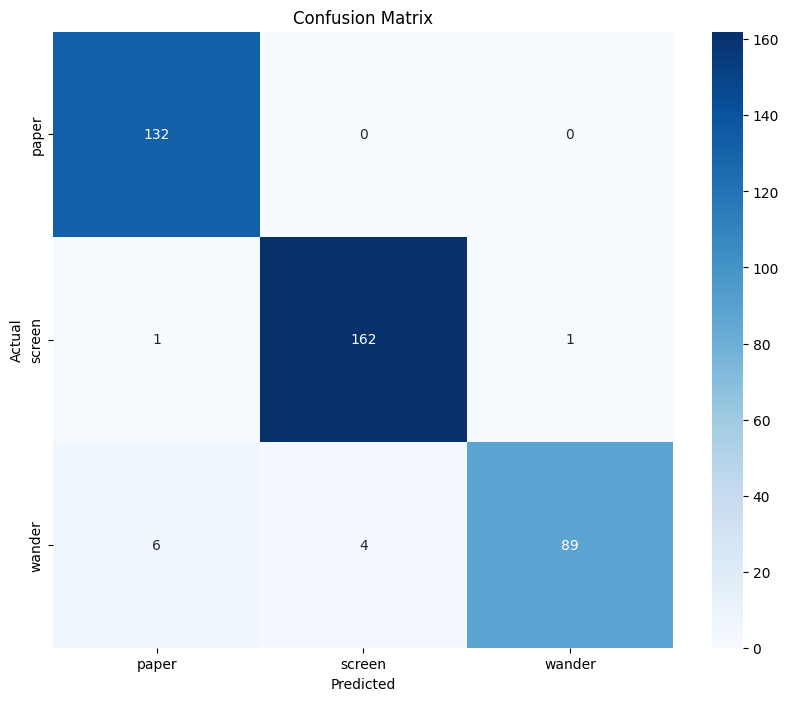

In [29]:
# Ensure the same preprocessing pipeline is applied to the test set
test_generator = CustomImageDataGenerator().flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Don't shuffle for evaluation
)

# Step 3: Load the best saved model
best_model = load_model(f'./models/best_overall_model_fold_2.h5')
# best_model_path = f'./models/best_overall_model_fold_{fold_idx + 1}.h5'
print(f"Loaded best model from: {best_model_path}")

# best_model_path = f'best_model_fold_{best_fold_idx + 1}.h5'  # Adjust if necessary
# best_model = load_model(best_model_path)
# print(f"Loaded best model from: {best_model_path}")

# Step 4: Evaluate the model on the test set
results = best_model.evaluate(test_generator, verbose=1)
test_loss, test_accuracy = results[0], results[1]
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 5: Get predictions
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions
y_true = test_generator.classes

# Step 6: Calculate Metrics
# F1 Score
test_f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Test F1 Score: {test_f1}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# QAT training as finetuning

####  Secondary K-Fold Loop for QAT

In [28]:
# 1. Initialize K-Fold (Same as Primary Loop)
kfold_qat = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# 2. Initialize Tracking Variables for QAT
qat_fold_accuracies = []
qat_fold_f1_scores = []
best_qat_accuracy = 0
best_qat_fold_idx = -1

# 3. Define QAT Parameters
QAT_EPOCHS = 20  # Fine-tuning epochs after QAT

In [29]:
from keras.models import load_model

In [30]:
# 4. Iterate through each fold for QAT
for fold_idx, (train_index, test_index) in enumerate(kfold_qat.split(image_dataframe)):
    print(f"\nApplying QAT on fold {fold_idx + 1}/{num_folds}")

    train_data = image_dataframe.iloc[train_index]
    test_data = image_dataframe.iloc[test_index]

    # Data Generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='file_path',
        y_col='label',
        target_size=(img_width, img_height),
        batch_size=16,  # Increased batch size
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col='file_path',
        y_col='label',
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    # Paths
    saved_model_path = f'./models/best_model_fold_{fold_idx + 1}.h5'
    qat_model_path = f'./quantized_models/qat_model_fold_{fold_idx + 1}.h5'

    # Check if the saved model exists
    if not os.path.exists(saved_model_path):
        print(f"Saved model for fold {fold_idx + 1} not found at {saved_model_path}. Skipping QAT for this fold.")
        continue

    # 5. Load the Pretrained Model
    pretrained_model = load_model(saved_model_path)
    print(f"Loaded pretrained model for fold {fold_idx + 1}.")

    # 6. Apply Quantization-Aware Training (QAT)
    qat_model = tfmot.quantization.keras.quantize_model(pretrained_model)
    print(f"Applied QAT to the model for fold {fold_idx + 1}.")

    # 7. Compile the QAT Model
    qat_model.compile(
        loss='categorical_crossentropy',
        optimizer=SGD(learning_rate=0.01),  # Lower learning rate for fine-tuning
        metrics=['accuracy']
    )

    # 8. Define QAT Callbacks
    qat_callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
        ModelCheckpoint(
            filepath=qat_model_path,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        TensorBoard(log_dir=f'./logs/qat_fold_{fold_idx + 1}')
    ]



    # 10. Fine-Tune the QAT Model
    history_qat = qat_model.fit(
        train_generator,  # Reuse the train_generator from the primary loop
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=QAT_EPOCHS,
        validation_data=test_generator,
        callbacks=qat_callbacks,
        # class_weight=class_weight_dict  # Reuse class weights
    )

    # 11. Evaluation
    y_true_qat = test_generator.classes
    y_pred_probs_qat = qat_model.predict(test_generator, verbose=1)
    y_pred_qat = np.argmax(y_pred_probs_qat, axis=1)

    # Calculate metrics
    qat_accuracy = history_qat.history['val_accuracy'][-1]
    qat_fold_accuracies.append(qat_accuracy)
    print(f"Fold {fold_idx + 1} QAT Validation Accuracy: {qat_accuracy:.4f}")

    qat_f1 = f1_score(y_true_qat, y_pred_qat, average='weighted')
    qat_fold_f1_scores.append(qat_f1)
    print(f"Fold {fold_idx + 1} QAT Validation F1 Score: {qat_f1:.4f}")

    # 12. Plot and Save QAT Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(history_qat.history['loss'], label='QAT Training Loss', color='blue')
    plt.plot(history_qat.history['val_loss'], label='QAT Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'QAT Loss Curve - Fold {fold_idx + 1}')
    plt.legend()
    qat_loss_curve_path = f'./plots/loss/QAT_MNV2_loss_curve_fold_{fold_idx + 1}.png'
    plt.savefig(qat_loss_curve_path)
    plt.close()

    # 13. Plot and Save QAT Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(history_qat.history['accuracy'], label='QAT Training Accuracy', color='green')
    plt.plot(history_qat.history['val_accuracy'], label='QAT Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'QAT Accuracy Curve - Fold {fold_idx + 1}')
    plt.legend()
    qat_accuracy_curve_path = f'./plots/accuracy/QAT_MNV2_accuracy_curve_fold_{fold_idx + 1}.png'
    plt.savefig(qat_accuracy_curve_path)
    plt.close()

    # 14. Track the Best QAT Fold
    if qat_accuracy > best_qat_accuracy:
        best_qat_accuracy = qat_accuracy
        best_qat_fold_idx = fold_idx
        print(f"New best QAT model saved for fold {fold_idx + 1} with accuracy {qat_accuracy:.4f}")


Applying QAT on fold 1/5
Found 1578 validated image filenames belonging to 3 classes.
Found 395 validated image filenames belonging to 3 classes.


Loaded pretrained model for fold 1.
Applied QAT to the model for fold 1.
Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 1.4084 - accuracy: 0.7983
Epoch 1: val_accuracy improved from -inf to 0.62785, saving model to ./quantized_models/qat_model_fold_1.h5


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 28s 178ms/step - loss: 1.4084 - accuracy: 0.7983 - val_loss: 1.5903 - val_accuracy: 0.6278 - lr: 0.0100
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.9916 - accuracy: 0.8809
Epoch 2: val_accuracy improved from 0.62785 to 0.71899, saving model to ./quantized_models/qat_model_fold_1.h5
98/98 [==============================] - 16s 164ms/step - loss: 0.9916 - accuracy: 0.8809 - val_loss: 1.3332 - val_accuracy: 0.7190 - lr: 0.0100
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.8445 - accuracy: 0.9309
Epoch 3: val_accuracy did not improve from 0.71899
98/98 [==============================] - 16s 159ms/step - loss: 0.8445 - accuracy: 0.9309 - val_loss: 1.3904 - val_accuracy: 0.6937 - lr: 0.0100
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 0.7822 - accuracy: 0.9392
Epoch 4: val_accuracy did not improve from 0.71899
98/98 [==============================] - 16s 159ms/step - loss: 0.7822

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 29s 178ms/step - loss: 1.2996 - accuracy: 0.7945 - val_loss: 1.7773 - val_accuracy: 0.4582 - lr: 0.0100
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.8586 - accuracy: 0.8841
Epoch 2: val_accuracy improved from 0.45823 to 0.69367, saving model to ./quantized_models/qat_model_fold_2.h5
98/98 [==============================] - 16s 164ms/step - loss: 0.8586 - accuracy: 0.8841 - val_loss: 1.3206 - val_accuracy: 0.6937 - lr: 0.0100
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.7180 - accuracy: 0.9251
Epoch 3: val_accuracy improved from 0.69367 to 0.72911, saving model to ./quantized_models/qat_model_fold_2.h5
98/98 [==============================] - 16s 165ms/step - loss: 0.7180 - accuracy: 0.9251 - val_loss: 1.3794 - val_accuracy: 0.7291 - lr: 0.0100
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.9501
Epoch 4: val_accuracy improved from 0.72911 to 0.82532, savin

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 28s 178ms/step - loss: 1.3683 - accuracy: 0.7561 - val_loss: 3.0457 - val_accuracy: 0.2532 - lr: 0.0100
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.8932 - accuracy: 0.8643
Epoch 2: val_accuracy improved from 0.25316 to 0.48101, saving model to ./quantized_models/qat_model_fold_3.h5
98/98 [==============================] - 16s 165ms/step - loss: 0.8932 - accuracy: 0.8643 - val_loss: 1.6323 - val_accuracy: 0.4810 - lr: 0.0100
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.9174
Epoch 3: val_accuracy improved from 0.48101 to 0.69367, saving model to ./quantized_models/qat_model_fold_3.h5
98/98 [==============================] - 16s 165ms/step - loss: 0.7349 - accuracy: 0.9174 - val_loss: 1.1610 - val_accuracy: 0.6937 - lr: 0.0100
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.9277
Epoch 4: val_accuracy improved from 0.69367 to 0.83291, savin

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 28s 179ms/step - loss: 1.3419 - accuracy: 0.7953 - val_loss: 1.9588 - val_accuracy: 0.2741 - lr: 0.0100
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.9174 - accuracy: 0.8823
Epoch 2: val_accuracy improved from 0.27411 to 0.73096, saving model to ./quantized_models/qat_model_fold_4.h5
98/98 [==============================] - 16s 166ms/step - loss: 0.9174 - accuracy: 0.8823 - val_loss: 1.1830 - val_accuracy: 0.7310 - lr: 0.0100
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.7961 - accuracy: 0.9175
Epoch 3: val_accuracy improved from 0.73096 to 0.80457, saving model to ./quantized_models/qat_model_fold_4.h5
98/98 [==============================] - 16s 166ms/step - loss: 0.7961 - accuracy: 0.9175 - val_loss: 1.1012 - val_accuracy: 0.8046 - lr: 0.0100
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.9443
Epoch 4: val_accuracy did not improve from 0.80457
98/98 [===

In [27]:
# 5. Final Evaluation Across QAT Folds
avg_qat_accuracy = np.mean(qat_fold_accuracies)
std_qat_accuracy = np.std(qat_fold_accuracies)
avg_qat_f1 = np.mean(qat_fold_f1_scores)
std_qat_f1 = np.std(qat_fold_f1_scores)  # Added standard deviation for F1 scores

for fold_idx in range(num_folds):
    print(f"Fold {fold_idx + 1} QAT Accuracy: {qat_fold_accuracies[fold_idx]:.4f}")
    print(f"Fold {fold_idx + 1} QAT F1 Score: {qat_fold_f1_scores[fold_idx]:.4f}")

print("Average QAT Validation Accuracy:", avg_qat_accuracy)
print("Standard Deviation of QAT Validation Accuracy:", std_qat_accuracy)
print("Average QAT F1 Score:", avg_qat_f1)
print("Standard Deviation of QAT F1 Score:", std_qat_f1)  # Printed std for F1 scores

print(f"\nBest QAT Fold: {best_qat_fold_idx + 1} with Validation Accuracy: {best_qat_accuracy:.4f}")

Fold 1 QAT Accuracy: 0.9063
Fold 1 QAT F1 Score: 0.9045
Fold 2 QAT Accuracy: 0.9494
Fold 2 QAT F1 Score: 0.9509
Fold 3 QAT Accuracy: 0.9671
Fold 3 QAT F1 Score: 0.9698
Fold 4 QAT Accuracy: 0.9112
Fold 4 QAT F1 Score: 0.9079
Fold 5 QAT Accuracy: 0.9619
Fold 5 QAT F1 Score: 0.9536
Average QAT Validation Accuracy: 0.9391762495040894
Standard Deviation of QAT Validation Accuracy: 0.02555019846176908
Average QAT F1 Score: 0.9373380168400158
Standard Deviation of QAT F1 Score: 0.0262452003486703

Best QAT Fold: 3 with Validation Accuracy: 0.9671


-------

loading saved validation split

In [70]:
# Step 1: Load the saved validation set
val_set_path = f'best_fold_{best_fold_idx + 1}_validation_data.csv'  # Adjust fold index if needed
val_data_qat = pd.read_csv(val_set_path)
print(f"Loaded validation set from: {val_set_path}")
print(f"Validation samples for QAT: {len(val_data_qat)}")

Loaded validation set from: best_fold_2_validation_data.csv
Validation samples for QAT: 395


Create training set by excluding validation samples

In [71]:
# Step 2: Create training set by excluding validation samples
train_data_qat = image_dataframe[~image_dataframe['file_path'].isin(val_data_qat['file_path'])]
print(f"Training samples for QAT: {len(train_data_qat)}")

# Step 3: Define image dimensions and batch size
img_width, img_height = 128, 128
batch_size = 16

Training samples for QAT: 1578


In [72]:
# Step 4: Initialize data generators (reuse original augmentations)
train_datagen_qat = CustomImageDataGenerator(  # Ensure all augmentations are identical
    channel_shift_range=0.1,
    # Include all original augmentation parameters
)

In [73]:
val_datagen_qat = CustomImageDataGenerator()  # No augmentations for validation

In [74]:
# Step 5: Create training generator (with augmentations)
train_generator_qat = train_datagen_qat.flow_from_dataframe(
    dataframe=train_data_qat,
    x_col='file_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Step 6: Create validation generator (without augmentations)
val_generator_qat = val_datagen_qat.flow_from_dataframe(
    dataframe=val_data_qat,
    x_col='file_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No shuffle for validation set
)


Found 1578 validated image filenames belonging to 3 classes.
Found 395 validated image filenames belonging to 3 classes.


In [75]:
# Step 7: Load the pretrained model
pretrained_model = tf.keras.models.load_model('./models/best_overall_model_fold_2.h5')
print("Loaded pretrained model for QAT fine-tuning.")

Loaded pretrained model for QAT fine-tuning.


In [76]:
pretrained_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

In [77]:
import keras

In [78]:
# Function to apply quantization to Dense layers only
def apply_quantization_to_dense(layer):
    if isinstance(layer, keras.layers.Dense):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [79]:
annotated_model = tf.keras.models.clone_model(
        pretrained_model,
        clone_function=apply_quantization_to_dense,
    )

In [80]:
# Step 8: Apply Quantization-Aware Training (QAT)
qat_model = tfmot.quantization.keras.quantize_model(annotated_model)
print("Converted model to QAT.")

Converted model to QAT.


In [85]:
# Step 9: Compile the QAT model
opt = SGD(learning_rate=0.01)  # Define optimizer
qat_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [86]:
# Step 10: Define callbacks
early_stopping_qat = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 11: Fine-tune the QAT model
qat_history = qat_model.fit(
    train_generator_qat,
    steps_per_epoch=train_generator_qat.samples // train_generator_qat.batch_size,
    epochs=15,  # Adjust fine-tuning epochs as needed
    validation_data=val_generator_qat,
    callbacks=[early_stopping_qat]
)

Epoch 1/15


98/98 [==============================] - 29s 175ms/step - loss: 0.2903 - accuracy: 0.9891 - val_loss: 0.3826 - val_accuracy: 0.9570
Epoch 2/15
98/98 [==============================] - 16s 161ms/step - loss: 0.2827 - accuracy: 0.9866 - val_loss: 0.3611 - val_accuracy: 0.9646
Epoch 3/15
98/98 [==============================] - 16s 161ms/step - loss: 0.2966 - accuracy: 0.9757 - val_loss: 0.3559 - val_accuracy: 0.9671
Epoch 4/15
98/98 [==============================] - 16s 162ms/step - loss: 0.2573 - accuracy: 0.9885 - val_loss: 0.3926 - val_accuracy: 0.9519
Epoch 5/15
98/98 [==============================] - 16s 160ms/step - loss: 0.2539 - accuracy: 0.9891 - val_loss: 0.3849 - val_accuracy: 0.9443
Epoch 6/15
98/98 [==============================] - 16s 161ms/step - loss: 0.2507 - accuracy: 0.9834 - val_loss: 0.3631 - val_accuracy: 0.9620
Epoch 7/15
98/98 [==============================] - 16s 162ms/step - loss: 0.2401 - accuracy: 0.9898 - val_loss: 0.3948 - val_accuracy: 0.9519
Epoch 8/15

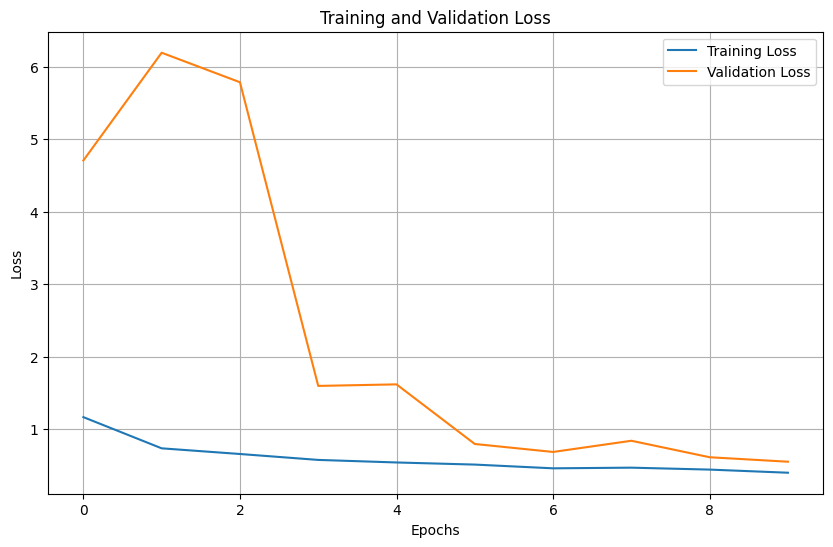

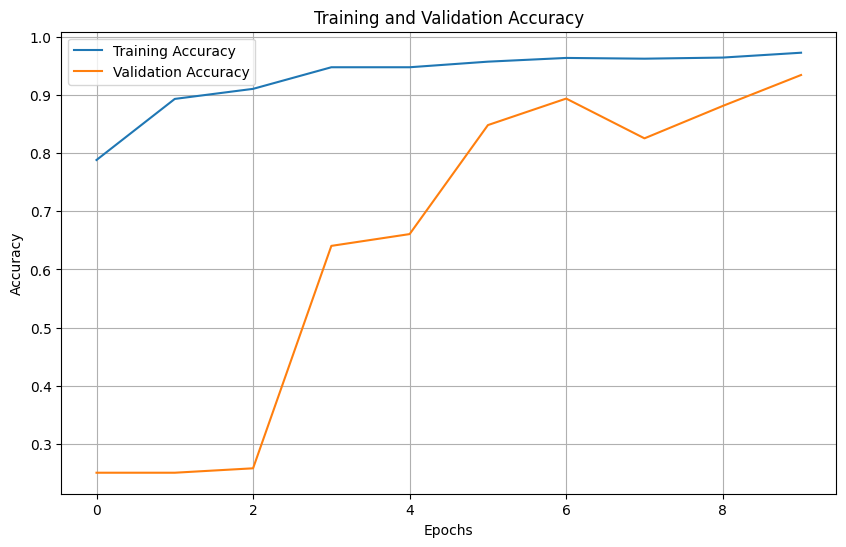

In [40]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(qat_history.history['loss'], label='Training Loss')
plt.plot(qat_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(qat_history.history['accuracy'], label='Training Accuracy')
plt.plot(qat_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Quantizing model after QAT training

In [41]:
# Provide a representative dataset for better quantization accuracy
def representative_data_gen():
    # Number of samples you want to use for calibration
    num_samples = 100
    count = 0
    
    for input_value, _ in train_generator_qat:
        yield [input_value]
        count += 1
        if count >= num_samples:
            break

In [42]:
converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)

# Enable full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_data_gen

# Convert and save the model
tflite_model = converter.convert()
with open("fully_quantized_model_int8.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpv246u0wx/assets


INFO:tensorflow:Assets written to: /tmp/tmpv246u0wx/assets
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-01-16 13:50:24.358074: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-01-16 13:50:24.358127: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-01-16 13:50:24.358723: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpv246u0wx
2025-01-16 13:50:24.391904: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-01-16 13:50:24.391956: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpv246u0wx
2025-01-16 13:50:24.461341: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 opti

Testing QAT quantized model on saved test set

In [43]:
# Step 1: Load the saved validation set
val_set_path = f'best_fold_{best_fold_idx + 1}_validation_data.csv'  # Adjust fold index if needed
val_data_qat = pd.read_csv(val_set_path)
print(f"Loaded validation set from: {val_set_path}")
print(f"Validation samples: {len(val_data_qat)}")

# Step 2: Create a validation generator
img_width, img_height = 128, 128
batch_size = 1

# Define the test data generator (no augmentation)
val_datagen_qat = CustomImageDataGenerator()  # No augmentations for validation

val_generator_qat = val_datagen_qat.flow_from_dataframe(
    dataframe=val_data_qat,
    x_col='file_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure order matches for true labels and predictions
)

Loaded validation set from: best_fold_2_validation_data.csv
Validation samples: 395
Found 395 validated image filenames belonging to 3 classes.


In [44]:
# Load the TensorFlow Lite model
tflite_model_path = "fully_quantized_model_int8.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

In [45]:
# Allocate tensors
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [46]:
# Display input details including quantization parameters
print("Input Details with Quantization Parameters:")
for input_detail in input_details:
    print(f"  Name: {input_detail['name']}")
    print(f"  Shape: {input_detail['shape']}")
    print(f"  Data Type: {input_detail['dtype']}")
    print(f"  Quantization Parameters: {input_detail['quantization']}")
    print(f"  Quantization Scale: {input_detail['quantization_parameters']['scales']}")
    print(f"  Quantization Zero Points: {input_detail['quantization_parameters']['zero_points']}")
    print()

# Display output details including quantization parameters
print("\nOutput Details with Quantization Parameters:")
for output_detail in output_details:
    print(f"  Name: {output_detail['name']}")
    print(f"  Shape: {output_detail['shape']}")
    print(f"  Data Type: {output_detail['dtype']}")
    print(f"  Quantization Parameters: {output_detail['quantization']}")
    print(f"  Quantization Scale: {output_detail['quantization_parameters']['scales']}")
    print(f"  Quantization Zero Points: {output_detail['quantization_parameters']['zero_points']}")
    print()

Input Details with Quantization Parameters:
  Name: serving_default_input_5:0
  Shape: [  1 128 128   3]
  Data Type: <class 'numpy.int8'>
  Quantization Parameters: (0.007843137718737125, 0)
  Quantization Scale: [0.00784314]
  Quantization Zero Points: [0]


Output Details with Quantization Parameters:
  Name: StatefulPartitionedCall:0
  Shape: [1 3]
  Data Type: <class 'numpy.int8'>
  Quantization Parameters: (0.00390625, -128)
  Quantization Scale: [0.00390625]
  Quantization Zero Points: [-128]



In [47]:
from sklearn.metrics import accuracy_score

In [48]:
# Function to run inference using TFLite model
def run_inference_tflite(interpreter, input_data):
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    return output

# Step 4: Collect predictions
y_pred = []
y_true = []

for i in range(len(val_generator_qat)):
    X_batch, y_batch = val_generator_qat[i]
    
    # Convert to required input type (int8 if the model expects it)
    input_data = X_batch.astype(np.float32)  # Change dtype if necessary

    # If model expects int8 inputs
    if input_details[0]['dtype'] == np.int8:
        input_scale, input_zero_point = input_details[0]['quantization']
        input_data = (input_data / input_scale + input_zero_point).astype(np.int8)
    
    # Run inference
    predictions = run_inference_tflite(interpreter, input_data)
    
    # If output is quantized, dequantize it
    if output_details[0]['dtype'] == np.int8:
        output_scale, output_zero_point = output_details[0]['quantization']
        predictions = (predictions.astype(np.float32) - output_zero_point) * output_scale
    
    y_pred.append(predictions)
    y_true.append(y_batch)

# Step 5: Evaluate Performance
# Concatenate all batches
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Compute Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9316
Precision: 0.9276
Recall: 0.9325
F1-Score: 0.9291


# Small Model MBNV1 0.25

In [16]:
# 1. Define the Input layer
input_layer = Input(shape=(img_width, img_height, 3))

# 2. Load the pre-trained MobileNetV2 model without the top classification layers
base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_layer, input_shape=(img_width, img_height, 3), alpha=0.25)
base_model.trainable = True

# 4. Add custom layers on top of the base_model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x) 
x = Dropout(0.6)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# 5. Create the Functional API model
small_model = Model(inputs=input_layer, outputs=output_layer)

# 6. Compile the model with the SGD optimizer
opt = SGD(learning_rate=0.01)
small_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [17]:
small_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 8)         216       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 8)         32        
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 8)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 8)         72        
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 8)         32  

### no QAT

In [19]:
# Initialize variables to track the best fold
best_fold_idx = -1
best_accuracy = -1
best_test_data = None

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1_scores = []

In [20]:
for fold_idx, (train_index, test_index) in enumerate(kfold.split(image_dataframe)):
    print(f"Training fold {fold_idx + 1}/{num_folds}")

    train_data = image_dataframe.iloc[train_index]
    test_data = image_dataframe.iloc[test_index]

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='file_path',
        y_col='label',
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col='file_path',
        y_col='label',
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    # 1. Define the Input layer
    input_layer = Input(shape=(img_width, img_height, 3))
    
    # 2. Load the pre-trained MobileNetV2 model without the top classification layers
    base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_layer, input_shape=(img_width, img_height, 3), alpha=0.25)
    base_model.trainable = True
    
    # 4. Add custom layers on top of the base_model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Removed activation from here
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  # Added Activation layer separately
    x = Dropout(0.6)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    # 5. Create the Functional API model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # 6. Compile the model with the SGD optimizer
    opt = SGD(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # 7. Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
        ModelCheckpoint(
            filepath=f'./models/best_small_model_fold_{fold_idx + 1}.h5',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        TensorBoard(log_dir=f'./logs/fold_{fold_idx + 1}')
    ]


    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=100,
        validation_data=test_generator,
        callbacks=callbacks
    )
    
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    accuracy = history.history['val_accuracy'][-1]
    fold_accuracies.append(accuracy)
    print(f"Fold {fold_idx + 1} Validation Accuracy: {accuracy:.4f}")

    f1 = f1_score(y_true, y_pred, average='weighted')
    fold_f1_scores.append(f1)
    print(f"Fold {fold_idx + 1} Validation F1 Score: {f1:.4f}")

    # 10. Plot and Save Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - Fold {fold_idx + 1}')
    plt.legend()
    loss_curve_path = f'./plots/loss/MNV2_loss_curve_fold_{fold_idx + 1}.png'
    plt.savefig(loss_curve_path)
    plt.close()

    # 11. Plot and Save Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - Fold {fold_idx + 1}')
    plt.legend()
    accuracy_curve_path = f'./plots/accuracy/MNV2_accuracy_curve_fold_{fold_idx + 1}.png'
    plt.savefig(accuracy_curve_path)
    plt.close()

    # 12. Track the Best Fold
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold_idx = fold_idx
        best_test_data = test_data.copy()
        best_model_path = f'./models/best_overall_small_model_fold_{fold_idx + 1}.h5'
        model.save(best_model_path)
        print(f"New best model saved for fold {fold_idx + 1} with accuracy {accuracy:.4f}")

# 13. Final Evaluation Across Folds
avg_accuracy = np.mean(fold_accuracies)
avg_f1 = np.mean(fold_f1_scores)
print(f"\nAverage Validation Accuracy across all folds: {avg_accuracy:.4f}")
print(f"Average Validation F1 Score across all folds: {avg_f1:.4f}")

print(f"\nBest Fold: {best_fold_idx + 1} with Validation Accuracy: {best_accuracy:.4f}")

Training fold 1/5
Found 1578 validated image filenames belonging to 3 classes.
Found 395 validated image filenames belonging to 3 classes.


Epoch 1/100


2025-01-19 12:32:11.587168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-01-19 12:32:13.211206: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f05b1745aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-19 12:32:13.211241: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-01-19 12:32:13.311242: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 [==============================] - ETA: 0s - loss: 2.7100 - accuracy: 0.5621
Epoch 1: val_accuracy improved from -inf to 0.65316, saving model to ./models/best_small_model_fold_1.h5
98/98 [==============================] - 16s 95ms/step - loss: 2.7100 - accuracy: 0.5621 - val_loss: 2.4111 - val_accuracy: 0.6532 - lr: 0.0100
Epoch 2/100


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - ETA: 0s - loss: 2.2482 - accuracy: 0.7484
Epoch 2: val_accuracy improved from 0.65316 to 0.81519, saving model to ./models/best_small_model_fold_1.h5
98/98 [==============================] - 9s 91ms/step - loss: 2.2482 - accuracy: 0.7484 - val_loss: 2.0250 - val_accuracy: 0.8152 - lr: 0.0100
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 2.0298 - accuracy: 0.8195
Epoch 3: val_accuracy did not improve from 0.81519
98/98 [==============================] - 8s 85ms/step - loss: 2.0298 - accuracy: 0.8195 - val_loss: 2.0325 - val_accuracy: 0.8051 - lr: 0.0100
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 1.9436 - accuracy: 0.8355
Epoch 4: val_accuracy improved from 0.81519 to 0.84810, saving model to ./models/best_small_model_fold_1.h5
98/98 [==============================] - 8s 86ms/step - loss: 1.9436 - accuracy: 0.8355 - val_loss: 1.8491 - val_accuracy: 0.8481 - lr: 0.0100
Epoch 5/100
98/98 [============

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 2.6965 - accuracy: 0.5832
Epoch 1: val_accuracy improved from -inf to 0.69873, saving model to ./models/best_small_model_fold_2.h5
98/98 [==============================] - 12s 86ms/step - loss: 2.6965 - accuracy: 0.5832 - val_loss: 2.4336 - val_accuracy: 0.6987 - lr: 0.0100
Epoch 2/100


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - ETA: 0s - loss: 2.2220 - accuracy: 0.7490
Epoch 2: val_accuracy improved from 0.69873 to 0.86076, saving model to ./models/best_small_model_fold_2.h5
98/98 [==============================] - 9s 88ms/step - loss: 2.2220 - accuracy: 0.7490 - val_loss: 2.0008 - val_accuracy: 0.8608 - lr: 0.0100
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 2.0859 - accuracy: 0.8003
Epoch 3: val_accuracy did not improve from 0.86076
98/98 [==============================] - 8s 83ms/step - loss: 2.0859 - accuracy: 0.8003 - val_loss: 1.9062 - val_accuracy: 0.8557 - lr: 0.0100
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 1.9447 - accuracy: 0.8303
Epoch 4: val_accuracy improved from 0.86076 to 0.87595, saving model to ./models/best_small_model_fold_2.h5
98/98 [==============================] - 9s 91ms/step - loss: 1.9447 - accuracy: 0.8303 - val_loss: 1.8179 - val_accuracy: 0.8759 - lr: 0.0100
Epoch 5/100
98/98 [============

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 2.6858 - accuracy: 0.5864
Epoch 1: val_accuracy improved from -inf to 0.64304, saving model to ./models/best_small_model_fold_3.h5
98/98 [==============================] - 13s 93ms/step - loss: 2.6858 - accuracy: 0.5864 - val_loss: 2.5424 - val_accuracy: 0.6430 - lr: 0.0100
Epoch 2/100


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - ETA: 0s - loss: 2.2426 - accuracy: 0.7407
Epoch 2: val_accuracy improved from 0.64304 to 0.83544, saving model to ./models/best_small_model_fold_3.h5
98/98 [==============================] - 8s 85ms/step - loss: 2.2426 - accuracy: 0.7407 - val_loss: 2.0810 - val_accuracy: 0.8354 - lr: 0.0100
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 2.0767 - accuracy: 0.7964
Epoch 3: val_accuracy improved from 0.83544 to 0.85316, saving model to ./models/best_small_model_fold_3.h5
98/98 [==============================] - 9s 89ms/step - loss: 2.0767 - accuracy: 0.7964 - val_loss: 1.9304 - val_accuracy: 0.8532 - lr: 0.0100
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 1.9412 - accuracy: 0.8399
Epoch 4: val_accuracy improved from 0.85316 to 0.89873, saving model to ./models/best_small_model_fold_3.h5
98/98 [==============================] - 8s 83ms/step - loss: 1.9412 - accuracy: 0.8399 - val_loss: 1.7901 - val_accu

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 2.6983 - accuracy: 0.5611
Epoch 1: val_accuracy improved from -inf to 0.61421, saving model to ./models/best_small_model_fold_4.h5
98/98 [==============================] - 13s 93ms/step - loss: 2.6983 - accuracy: 0.5611 - val_loss: 2.6047 - val_accuracy: 0.6142 - lr: 0.0100
Epoch 2/100


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - ETA: 0s - loss: 2.2391 - accuracy: 0.7486
Epoch 2: val_accuracy improved from 0.61421 to 0.73604, saving model to ./models/best_small_model_fold_4.h5
98/98 [==============================] - 8s 86ms/step - loss: 2.2391 - accuracy: 0.7486 - val_loss: 2.2091 - val_accuracy: 0.7360 - lr: 0.0100
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 2.0124 - accuracy: 0.8106
Epoch 3: val_accuracy improved from 0.73604 to 0.82234, saving model to ./models/best_small_model_fold_4.h5
98/98 [==============================] - 8s 84ms/step - loss: 2.0124 - accuracy: 0.8106 - val_loss: 1.9941 - val_accuracy: 0.8223 - lr: 0.0100
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 1.9213 - accuracy: 0.8381
Epoch 4: val_accuracy did not improve from 0.82234
98/98 [==============================] - 9s 88ms/step - loss: 1.9213 - accuracy: 0.8381 - val_loss: 1.9007 - val_accuracy: 0.8198 - lr: 0.0100
Epoch 5/100
98/98 [============

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - ETA: 0s - loss: 2.2681 - accuracy: 0.7383
Epoch 2: val_accuracy improved from 0.67005 to 0.83756, saving model to ./models/best_small_model_fold_5.h5
98/98 [==============================] - 9s 88ms/step - loss: 2.2681 - accuracy: 0.7383 - val_loss: 2.0221 - val_accuracy: 0.8376 - lr: 0.0100
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 2.0354 - accuracy: 0.8061
Epoch 3: val_accuracy improved from 0.83756 to 0.86802, saving model to ./models/best_small_model_fold_5.h5
98/98 [==============================] - 8s 84ms/step - loss: 2.0354 - accuracy: 0.8061 - val_loss: 1.8514 - val_accuracy: 0.8680 - lr: 0.0100
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 1.9284 - accuracy: 0.8349
Epoch 4: val_accuracy improved from 0.86802 to 0.88325, saving model to ./models/best_small_model_fold_5.h5
98/98 [==============================] - 9s 88ms/step - loss: 1.9284 - accuracy: 0.8349 - val_loss: 1.7627 - val_accu

In [21]:
avg_test_acc = np.mean(fold_accuracies)
std_test_acc = np.std(fold_accuracies)
avg_f1_score = np.mean(fold_f1_scores)

for fold_idx in range(num_folds):
    print(f"Fold {fold_idx + 1} Accuracy: {fold_accuracies[fold_idx]}")
    print(f"Fold {fold_idx + 1} F1 Score: {fold_f1_scores[fold_idx]}")
    
print("Average Test accuracy:", avg_test_acc)
print("Standard Deviation of Test accuracy:", std_test_acc)
print("Average F1 Score:", avg_f1_score)

Fold 1 Accuracy: 0.9139240384101868
Fold 1 F1 Score: 0.9236447767388417
Fold 2 Accuracy: 0.9518987536430359
Fold 2 F1 Score: 0.9566658394523077
Fold 3 Accuracy: 0.9645569324493408
Fold 3 F1 Score: 0.9442377668247889
Fold 4 Accuracy: 0.913705587387085
Fold 4 F1 Score: 0.9157040729263772
Fold 5 Accuracy: 0.9543147087097168
Fold 5 F1 Score: 0.956740127073351
Average Test accuracy: 0.9396800041198731
Standard Deviation of Test accuracy: 0.021542395761374077
Average F1 Score: 0.9393985166031333


# Saving Best Split

In [ ]:
# After all folds, save the best test fold to a file
if best_test_data is not None:
    best_test_data.to_csv(f'best_fold_{best_fold_idx + 1}_validation_data.csv', index=False)
    print(f"Best fold {best_fold_idx + 1} with accuracy {best_accuracy} saved as validation data.")
    print(f"Best model saved at {best_model_path}")

Best fold 4 with accuracy 0.9492385983467102 saved as validation data.
Best model saved at best_model_fold_4.keras


Convert the Keras model to a TFLite model (No Quantization)

In [ ]:
model = tf.keras.models.load_model('best_model_fold_4.keras')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('best_model_fold_4.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpc62ih_ay/assets


INFO:tensorflow:Assets written to: /tmp/tmpc62ih_ay/assets
2024-11-15 20:10:51.314296: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-11-15 20:10:51.314312: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-11-15 20:10:51.314532: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpc62ih_ay
2024-11-15 20:10:51.325113: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-11-15 20:10:51.325123: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpc62ih_ay
2024-11-15 20:10:51.345569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-11-15 20:10:51.354250: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-11-15 20:10:51.570968: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

# testing model on exported test set

In [ ]:
# Load the exported test set
test_set_path = f'best_fold_{best_fold_idx + 1}_validation_data.csv'
test_df = pd.read_csv(test_set_path)
print(f"Loaded test data from {test_set_path}")
print(test_df.head())

Loaded test data from best_fold_4_validation_data.csv
                                           file_path   label
0  /home/sec_team2/Engagement/Dataset/screen/1651...  screen
1  /home/sec_team2/Engagement/Dataset/screen/1814...  screen
2  /home/sec_team2/Engagement/Dataset/screen/1657...  screen
3  /home/sec_team2/Engagement/Dataset/screen/1644...  screen
4  /home/sec_team2/Engagement/Dataset/screen/1646...  screen


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

Found 394 validated image filenames belonging to 3 classes.
Loaded best model from: best_model_fold_4.keras
25/25 [==============================] - 2s 59ms/step - loss: 0.5363 - accuracy: 0.9416
Test Loss: 0.5362608432769775
Test Accuracy: 0.9416243433952332
25/25 [==============================] - 2s 57ms/step
Test F1 Score: 0.954227492317899
Classification Report:
              precision    recall  f1-score   support

       paper       0.96      0.98      0.97       112
      screen       0.94      0.96      0.95       156
      wander       0.97      0.93      0.95       126

    accuracy                           0.95       394
   macro avg       0.96      0.96      0.96       394
weighted avg       0.95      0.95      0.95       394



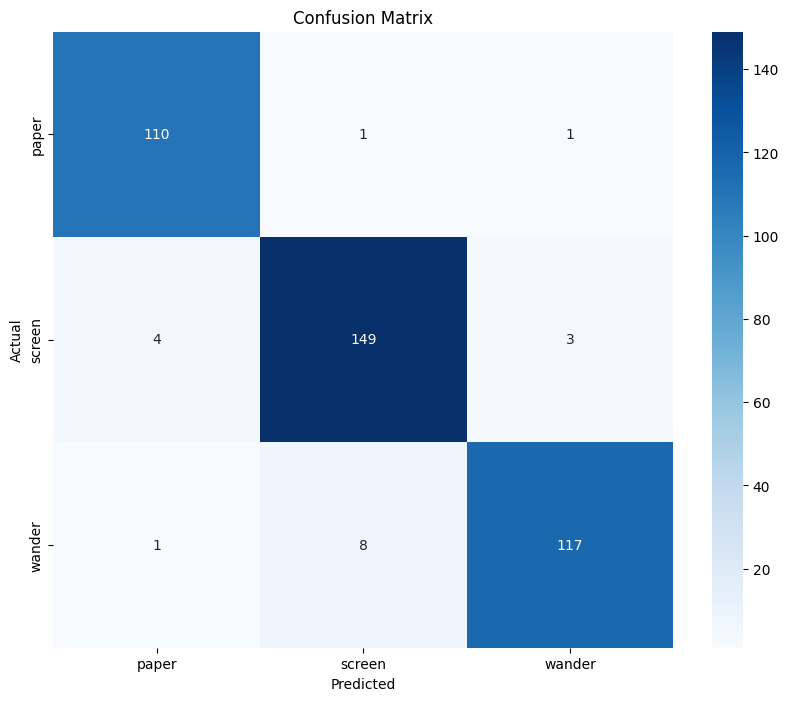

In [ ]:
# Ensure the same preprocessing pipeline is applied to the test set
test_generator = CustomImageDataGenerator().flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Don't shuffle for evaluation
)

# Step 3: Load the best saved model
best_model = load_model(f'best_model_fold_{best_fold_idx + 1}.keras')
print(f"Loaded best model from: {best_model_path}")

# best_model_path = f'best_model_fold_{best_fold_idx + 1}.h5'  # Adjust if necessary
# best_model = load_model(best_model_path)
# print(f"Loaded best model from: {best_model_path}")

# Step 4: Evaluate the model on the test set
results = best_model.evaluate(test_generator, verbose=1)
test_loss, test_accuracy = results[0], results[1]
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 5: Get predictions
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions
y_true = test_generator.classes

# Step 6: Calculate Metrics
# F1 Score
test_f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Test F1 Score: {test_f1}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# QAT training as finetuning

------

####  Secondary K-Fold Loop for QAT

In [17]:
# 1. Initialize K-Fold (Same as Primary Loop)
kfold_qat = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# 2. Initialize Tracking Variables for QAT
qat_fold_accuracies = []
qat_fold_f1_scores = []
best_qat_accuracy = 0
best_qat_fold_idx = -1

# 3. Define QAT Parameters
QAT_EPOCHS = 20  # Fine-tuning epochs after QAT

In [18]:
from keras.models import load_model

In [19]:
# 4. Iterate through each fold for QAT
for fold_idx, (train_index, test_index) in enumerate(kfold_qat.split(image_dataframe)):
    print(f"\nApplying QAT on fold {fold_idx + 1}/{num_folds}")

    train_data = image_dataframe.iloc[train_index]
    test_data = image_dataframe.iloc[test_index]

    # Data Generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='file_path',
        y_col='label',
        target_size=(img_width, img_height),
        batch_size=16,  # Increased batch size
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col='file_path',
        y_col='label',
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    # Paths
    saved_model_path = f'./models/best_small_model_fold_{fold_idx + 1}.h5'
    qat_model_path = f'./quantized_models/qat_small_model_fold_{fold_idx + 1}.h5'

    # Check if the saved model exists
    if not os.path.exists(saved_model_path):
        print(f"Saved model for fold {fold_idx + 1} not found at {saved_model_path}. Skipping QAT for this fold.")
        continue

    # 5. Load the Pretrained Model
    pretrained_model = load_model(saved_model_path)
    print(f"Loaded pretrained model for fold {fold_idx + 1}.")

    # 6. Apply Quantization-Aware Training (QAT)
    qat_model = tfmot.quantization.keras.quantize_model(pretrained_model)
    print(f"Applied QAT to the model for fold {fold_idx + 1}.")

    # 7. Compile the QAT Model
    qat_model.compile(
        loss='categorical_crossentropy',
        optimizer=SGD(learning_rate=0.01),  # Lower learning rate for fine-tuning
        metrics=['accuracy']
    )

    # 8. Define QAT Callbacks
    qat_callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
        ModelCheckpoint(
            filepath=qat_model_path,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        TensorBoard(log_dir=f'./logs/qat_fold_{fold_idx + 1}')
    ]



    # 10. Fine-Tune the QAT Model
    history_qat = qat_model.fit(
        train_generator,  # Reuse the train_generator from the primary loop
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=QAT_EPOCHS,
        validation_data=test_generator,
        callbacks=qat_callbacks,
        # class_weight=class_weight_dict  # Reuse class weights
    )

    # 11. Evaluation
    y_true_qat = test_generator.classes
    y_pred_probs_qat = qat_model.predict(test_generator, verbose=1)
    y_pred_qat = np.argmax(y_pred_probs_qat, axis=1)

    # Calculate metrics
    qat_accuracy = history_qat.history['val_accuracy'][-1]
    qat_fold_accuracies.append(qat_accuracy)
    print(f"Fold {fold_idx + 1} QAT Validation Accuracy: {qat_accuracy:.4f}")

    qat_f1 = f1_score(y_true_qat, y_pred_qat, average='weighted')
    qat_fold_f1_scores.append(qat_f1)
    print(f"Fold {fold_idx + 1} QAT Validation F1 Score: {qat_f1:.4f}")

    # 12. Plot and Save QAT Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(history_qat.history['loss'], label='QAT Training Loss', color='blue')
    plt.plot(history_qat.history['val_loss'], label='QAT Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'QAT Loss Curve - Fold {fold_idx + 1}')
    plt.legend()
    qat_loss_curve_path = f'./plots/loss/QAT_MNV2_loss_curve_fold_{fold_idx + 1}.png'
    plt.savefig(qat_loss_curve_path)
    plt.close()

    # 13. Plot and Save QAT Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(history_qat.history['accuracy'], label='QAT Training Accuracy', color='green')
    plt.plot(history_qat.history['val_accuracy'], label='QAT Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'QAT Accuracy Curve - Fold {fold_idx + 1}')
    plt.legend()
    qat_accuracy_curve_path = f'./plots/accuracy/QAT_MNV2_accuracy_curve_fold_{fold_idx + 1}.png'
    plt.savefig(qat_accuracy_curve_path)
    plt.close()

    # 14. Track the Best QAT Fold
    if qat_accuracy > best_qat_accuracy:
        best_qat_accuracy = qat_accuracy
        best_qat_fold_idx = fold_idx
        print(f"New best QAT model saved for fold {fold_idx + 1} with accuracy {qat_accuracy:.4f}")


Applying QAT on fold 1/5
Found 1578 validated image filenames belonging to 3 classes.
Found 395 validated image filenames belonging to 3 classes.


Loaded pretrained model for fold 1.
Applied QAT to the model for fold 1.
Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 0.7658 - accuracy: 0.9469
Epoch 1: val_accuracy improved from -inf to 0.90633, saving model to ./quantized_models/qat_small_model_fold_1.h5
98/98 [==============================] - 15s 116ms/step - loss: 0.7658 - accuracy: 0.9469 - val_loss: 0.9123 - val_accuracy: 0.9063 - lr: 0.0100
Epoch 2/20


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - ETA: 0s - loss: 0.7596 - accuracy: 0.9379
Epoch 2: val_accuracy improved from 0.90633 to 0.90886, saving model to ./quantized_models/qat_small_model_fold_1.h5
98/98 [==============================] - 10s 105ms/step - loss: 0.7596 - accuracy: 0.9379 - val_loss: 0.8737 - val_accuracy: 0.9089 - lr: 0.0100
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.7207 - accuracy: 0.9494
Epoch 3: val_accuracy did not improve from 0.90886
98/98 [==============================] - 11s 111ms/step - loss: 0.7207 - accuracy: 0.9494 - val_loss: 0.8356 - val_accuracy: 0.9038 - lr: 0.0100
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.9456
Epoch 4: val_accuracy did not improve from 0.90886
98/98 [==============================] - 11s 108ms/step - loss: 0.6966 - accuracy: 0.9456 - val_loss: 0.9287 - val_accuracy: 0.9013 - lr: 0.0100
Epoch 5/20
98/98 [==============================] - ETA: 0s - loss: 0.6840 

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.9635
Epoch 2: val_accuracy improved from 0.93165 to 0.94177, saving model to ./quantized_models/qat_small_model_fold_2.h5
98/98 [==============================] - 11s 114ms/step - loss: 0.3895 - accuracy: 0.9635 - val_loss: 0.4816 - val_accuracy: 0.9418 - lr: 0.0100
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.3868 - accuracy: 0.9616
Epoch 3: val_accuracy improved from 0.94177 to 0.95190, saving model to ./quantized_models/qat_small_model_fold_2.h5
98/98 [==============================] - 11s 112ms/step - loss: 0.3868 - accuracy: 0.9616 - val_loss: 0.4558 - val_accuracy: 0.9519 - lr: 0.0100
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 0.3681 - accuracy: 0.9629
Epoch 4: val_accuracy did not improve from 0.95190
98/98 [==============================] - 10s 107ms/step - loss: 0.3681 - accuracy: 0.9629 - val_loss: 0.4874 - val_accuracy: 0.9316 - lr: 0.0100
Epoch 5/2

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.9680
Epoch 2: val_accuracy did not improve from 0.94937
98/98 [==============================] - 10s 105ms/step - loss: 0.2981 - accuracy: 0.9680 - val_loss: 0.3774 - val_accuracy: 0.9367 - lr: 0.0100
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.9693
Epoch 3: val_accuracy did not improve from 0.94937
98/98 [==============================] - 11s 107ms/step - loss: 0.2801 - accuracy: 0.9693 - val_loss: 0.3988 - val_accuracy: 0.9316 - lr: 0.0100
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.9673
Epoch 4: val_accuracy did not improve from 0.94937
98/98 [==============================] - 11s 114ms/step - loss: 0.2839 - accuracy: 0.9673 - val_loss: 0.3945 - val_accuracy: 0.9367 - lr: 0.0100
Epoch 5/20
98/98 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.9635
Epoch 5: val_accuracy did not improv

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - ETA: 0s - loss: 0.5750 - accuracy: 0.9405
Epoch 2: val_accuracy improved from 0.89340 to 0.89594, saving model to ./quantized_models/qat_small_model_fold_4.h5
98/98 [==============================] - 10s 106ms/step - loss: 0.5750 - accuracy: 0.9405 - val_loss: 0.7656 - val_accuracy: 0.8959 - lr: 0.0100
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.5243 - accuracy: 0.9616
Epoch 3: val_accuracy improved from 0.89594 to 0.91371, saving model to ./quantized_models/qat_small_model_fold_4.h5
98/98 [==============================] - 11s 111ms/step - loss: 0.5243 - accuracy: 0.9616 - val_loss: 0.6838 - val_accuracy: 0.9137 - lr: 0.0100
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 0.4989 - accuracy: 0.9559
Epoch 4: val_accuracy did not improve from 0.91371
98/98 [==============================] - 10s 105ms/step - loss: 0.4989 - accuracy: 0.9559 - val_loss: 0.6815 - val_accuracy: 0.8909 - lr: 0.0100
Epoch 5/2

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - ETA: 0s - loss: 0.8637 - accuracy: 0.9399
Epoch 2: val_accuracy did not improve from 0.94670
98/98 [==============================] - 10s 103ms/step - loss: 0.8637 - accuracy: 0.9399 - val_loss: 0.8265 - val_accuracy: 0.9340 - lr: 0.0100
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.8543 - accuracy: 0.9245
Epoch 3: val_accuracy did not improve from 0.94670
98/98 [==============================] - 11s 116ms/step - loss: 0.8543 - accuracy: 0.9245 - val_loss: 0.7937 - val_accuracy: 0.9340 - lr: 0.0100
Epoch 4/20
98/98 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.9354
Epoch 4: val_accuracy did not improve from 0.94670
98/98 [==============================] - 10s 103ms/step - loss: 0.8181 - accuracy: 0.9354 - val_loss: 0.8130 - val_accuracy: 0.9239 - lr: 0.0100
Epoch 5/20
98/98 [==============================] - ETA: 0s - loss: 0.7784 - accuracy: 0.9443
Epoch 5: val_accuracy improved from 0.94670 to 

In [20]:
# 5. Final Evaluation Across QAT Folds
avg_qat_accuracy = np.mean(qat_fold_accuracies)
std_qat_accuracy = np.std(qat_fold_accuracies)
avg_qat_f1 = np.mean(qat_fold_f1_scores)
std_qat_f1 = np.std(qat_fold_f1_scores)  # Added standard deviation for F1 scores

for fold_idx in range(num_folds):
    print(f"Fold {fold_idx + 1} QAT Accuracy: {qat_fold_accuracies[fold_idx]:.4f}")
    print(f"Fold {fold_idx + 1} QAT F1 Score: {qat_fold_f1_scores[fold_idx]:.4f}")

print("Average QAT Validation Accuracy:", avg_qat_accuracy)
print("Standard Deviation of QAT Validation Accuracy:", std_qat_accuracy)
print("Average QAT F1 Score:", avg_qat_f1)
print("Standard Deviation of QAT F1 Score:", std_qat_f1)  # Printed std for F1 scores

print(f"\nBest QAT Fold: {best_qat_fold_idx + 1} with Validation Accuracy: {best_qat_accuracy:.4f}")

Fold 1 QAT Accuracy: 0.9190
Fold 1 QAT F1 Score: 0.9107
Fold 2 QAT Accuracy: 0.9519
Fold 2 QAT F1 Score: 0.9669
Fold 3 QAT Accuracy: 0.9519
Fold 3 QAT F1 Score: 0.9518
Fold 4 QAT Accuracy: 0.9137
Fold 4 QAT F1 Score: 0.9136
Fold 5 QAT Accuracy: 0.9543
Fold 5 QAT F1 Score: 0.9720
Average QAT Validation Accuracy: 0.938161027431488
Standard Deviation of QAT Validation Accuracy: 0.017911397142492024
Average QAT F1 Score: 0.9430083122680408
Standard Deviation of QAT F1 Score: 0.02606519785460401

Best QAT Fold: 5 with Validation Accuracy: 0.9543


----

In [ ]:
# Step 1: Load the saved validation set
val_set_path = f'best_fold_{best_fold_idx + 1}_validation_data.csv'  # Adjust fold index if needed
val_data_qat = pd.read_csv(val_set_path)
print(f"Loaded validation set from: {val_set_path}")
print(f"Validation samples for QAT: {len(val_data_qat)}")

Loaded validation set from: best_fold_4_validation_data.csv
Validation samples for QAT: 394


In [ ]:
# Step 2: Create training set by excluding validation samples
train_data_qat = image_dataframe[~image_dataframe['file_path'].isin(val_data_qat['file_path'])]
print(f"Training samples for QAT: {len(train_data_qat)}")

# Step 3: Define image dimensions and batch size
img_width, img_height = 128, 128
batch_size = 16

Training samples for QAT: 1579


In [ ]:
# Step 4: Initialize data generators (reuse original augmentations)
train_datagen_qat = CustomImageDataGenerator(  # Ensure all augmentations are identical
    channel_shift_range=0.1,
    # Include all original augmentation parameters
)

In [ ]:
val_datagen_qat = CustomImageDataGenerator()  # No augmentations for validation

In [ ]:
# Step 5: Create training generator (with augmentations)
train_generator_qat = train_datagen_qat.flow_from_dataframe(
    dataframe=train_data_qat,
    x_col='file_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Step 6: Create validation generator (without augmentations)
val_generator_qat = val_datagen_qat.flow_from_dataframe(
    dataframe=val_data_qat,
    x_col='file_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # No shuffle for validation set
)


Found 1579 validated image filenames belonging to 3 classes.
Found 394 validated image filenames belonging to 3 classes.


In [ ]:
# Step 7: Load the pretrained model
pretrained_model = tf.keras.models.load_model('best_model_fold_4.keras')
print("Loaded pretrained model for QAT fine-tuning.")

Loaded pretrained model for QAT fine-tuning.


In [ ]:
pretrained_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 8)         216       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 8)         32        
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 8)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 8)         72        
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 8)         32  

In [ ]:
# Step 8: Apply Quantization-Aware Training (QAT)
qat_model = tfmot.quantization.keras.quantize_model(pretrained_model)
print("Converted model to QAT.")

Converted model to QAT.


In [ ]:
# Step 9: Compile the QAT model
opt = SGD(learning_rate=0.01)  # Define optimizer
qat_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Step 10: Define callbacks
lr_scheduler_qat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
early_stopping_qat = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 11: Fine-tune the QAT model
qat_history = qat_model.fit(
    train_generator_qat,
    steps_per_epoch=train_generator_qat.samples // train_generator_qat.batch_size,
    epochs=15,  # Adjust fine-tuning epochs as needed
    validation_data=val_generator_qat,
    callbacks=[lr_scheduler_qat, early_stopping_qat]
)

Epoch 1/15
98/98 [==============================] - 9s 97ms/step - loss: 0.3004 - accuracy: 0.9738 - val_loss: 0.4328 - val_accuracy: 0.9416 - lr: 1.0000e-03
Epoch 2/15
98/98 [==============================] - 9s 97ms/step - loss: 0.3065 - accuracy: 0.9699 - val_loss: 0.4851 - val_accuracy: 0.9391 - lr: 1.0000e-03
Epoch 3/15
98/98 [==============================] - 9s 95ms/step - loss: 0.3137 - accuracy: 0.9712 - val_loss: 0.4491 - val_accuracy: 0.9467 - lr: 1.0000e-03
Epoch 4/15
98/98 [==============================] - 9s 97ms/step - loss: 0.2963 - accuracy: 0.9782 - val_loss: 0.4831 - val_accuracy: 0.9391 - lr: 1.0000e-04
Epoch 5/15
98/98 [==============================] - 10s 98ms/step - loss: 0.2984 - accuracy: 0.9770 - val_loss: 0.4428 - val_accuracy: 0.9416 - lr: 1.0000e-04
Epoch 6/15
98/98 [==============================] - 10s 98ms/step - loss: 0.2814 - accuracy: 0.9859 - val_loss: 0.4764 - val_accuracy: 0.9315 - lr: 1.0000e-05


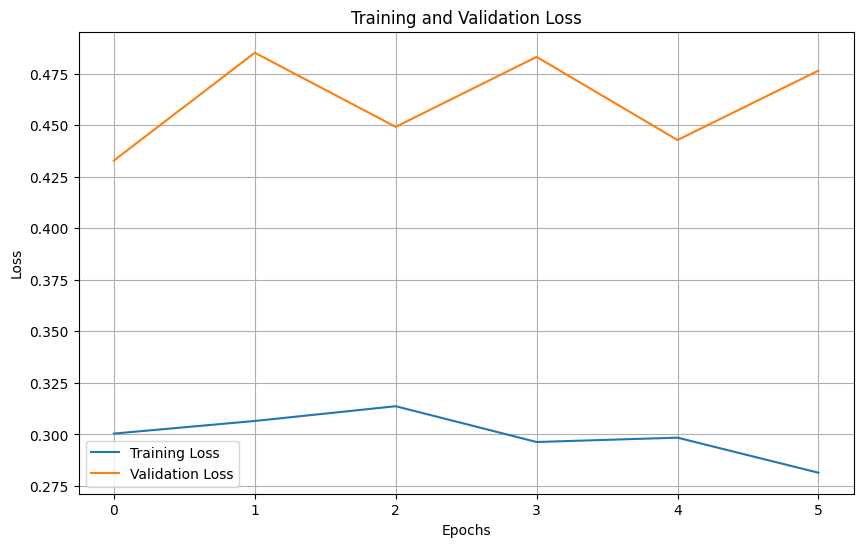

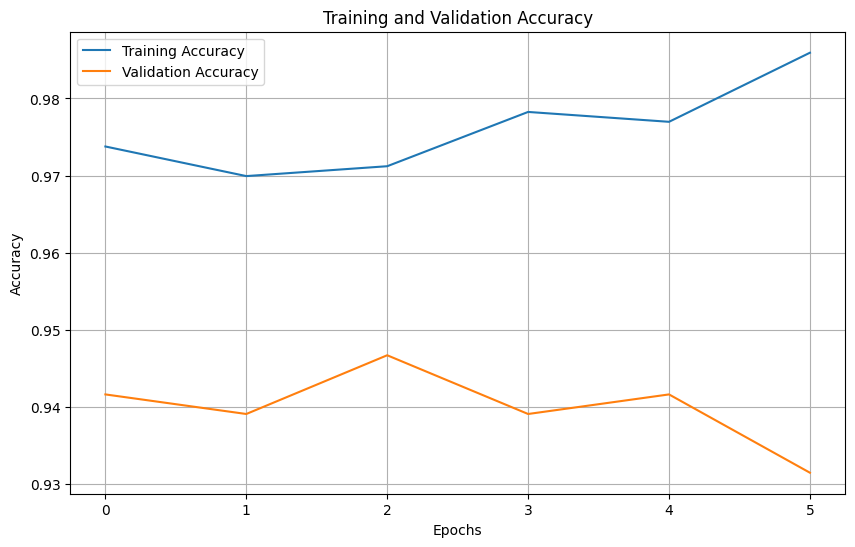

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(qat_history.history['loss'], label='Training Loss')
plt.plot(qat_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(qat_history.history['accuracy'], label='Training Accuracy')
plt.plot(qat_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Provide a representative dataset for better quantization accuracy
def representative_data_gen():
    # Number of samples you want to use for calibration
    num_samples = 300
    count = 0
    
    for input_value, _ in train_generator_qat:
        yield [input_value]
        count += 1
        if count >= num_samples:
            break

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)

# Enable full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_data_gen

# Convert and save the model
tflite_model = converter.convert()
with open("fully_quantized_small_model_int8.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpnp0quxu_/assets


INFO:tensorflow:Assets written to: /tmp/tmpnp0quxu_/assets
/home/sec_team2/anaconda3/envs/sony/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-11-15 20:46:53.302746: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-11-15 20:46:53.302764: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-11-15 20:46:53.302928: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpnp0quxu_
2024-11-15 20:46:53.324921: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-11-15 20:46:53.324933: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpnp0quxu_
2024-11-15 20:46:53.394512: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-1

In [ ]:
# Step 1: Load the saved validation set
val_set_path = f'best_fold_{best_fold_idx + 1}_validation_data.csv'  # Adjust fold index if needed
val_data_qat = pd.read_csv(val_set_path)
print(f"Loaded validation set from: {val_set_path}")
print(f"Validation samples: {len(val_data_qat)}")

# Step 2: Create a validation generator
img_width, img_height = 128, 128
batch_size = 1

# Define the test data generator (no augmentation)
val_datagen_qat = CustomImageDataGenerator()  # No augmentations for validation

val_generator_qat = val_datagen_qat.flow_from_dataframe(
    dataframe=val_data_qat,
    x_col='file_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure order matches for true labels and predictions
)

Loaded validation set from: best_fold_4_validation_data.csv
Validation samples: 394
Found 394 validated image filenames belonging to 3 classes.


In [ ]:
# Load the TensorFlow Lite model
tflite_model_path = "fully_quantized_small_model_int8.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

In [ ]:
# Allocate tensors
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Display input details including quantization parameters
print("Input Details with Quantization Parameters:")
for input_detail in input_details:
    print(f"  Name: {input_detail['name']}")
    print(f"  Shape: {input_detail['shape']}")
    print(f"  Data Type: {input_detail['dtype']}")
    print(f"  Quantization Parameters: {input_detail['quantization']}")
    print(f"  Quantization Scale: {input_detail['quantization_parameters']['scales']}")
    print(f"  Quantization Zero Points: {input_detail['quantization_parameters']['zero_points']}")
    print()

# Display output details including quantization parameters
print("\nOutput Details with Quantization Parameters:")
for output_detail in output_details:
    print(f"  Name: {output_detail['name']}")
    print(f"  Shape: {output_detail['shape']}")
    print(f"  Data Type: {output_detail['dtype']}")
    print(f"  Quantization Parameters: {output_detail['quantization']}")
    print(f"  Quantization Scale: {output_detail['quantization_parameters']['scales']}")
    print(f"  Quantization Zero Points: {output_detail['quantization_parameters']['zero_points']}")
    print()

Input Details with Quantization Parameters:
  Name: serving_default_input_7:0
  Shape: [  1 128 128   3]
  Data Type: <class 'numpy.int8'>
  Quantization Parameters: (0.007843137718737125, 0)
  Quantization Scale: [0.00784314]
  Quantization Zero Points: [0]


Output Details with Quantization Parameters:
  Name: StatefulPartitionedCall:0
  Shape: [1 3]
  Data Type: <class 'numpy.int8'>
  Quantization Parameters: (0.00390625, -128)
  Quantization Scale: [0.00390625]
  Quantization Zero Points: [-128]



In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Function to run inference using TFLite model
def run_inference_tflite(interpreter, input_data):
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    return output

# Step 4: Collect predictions
y_pred = []
y_true = []

for i in range(len(val_generator_qat)):
    X_batch, y_batch = val_generator_qat[i]
    
    # Convert to required input type (int8 if the model expects it)
    input_data = X_batch.astype(np.float32)  # Change dtype if necessary

    # If model expects int8 inputs
    if input_details[0]['dtype'] == np.int8:
        input_scale, input_zero_point = input_details[0]['quantization']
        input_data = (input_data / input_scale + input_zero_point).astype(np.int8)
    
    # Run inference
    predictions = run_inference_tflite(interpreter, input_data)
    
    # If output is quantized, dequantize it
    if output_details[0]['dtype'] == np.int8:
        output_scale, output_zero_point = output_details[0]['quantization']
        predictions = (predictions.astype(np.float32) - output_zero_point) * output_scale
    
    y_pred.append(predictions)
    y_true.append(y_batch)

# Step 5: Evaluate Performance
# Concatenate all batches
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Compute Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9365
Precision: 0.9375
Recall: 0.9395
F1-Score: 0.9384


convert to c header file

In [ ]:
import binascii

In [ ]:
def convert_to_c_array(bytes) -> str:
    hexstr = binascii.hexlify(bytes).decode("UTF-8")
    hexstr = hexstr.upper()
    array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
    array = [array[i:i+10] for i in range(0, len(array), 10)]
    return ",\n  ".join([", ".join(e) for e in array])

In [ ]:
tflite_binary = open('fully_quantized_small_model_int8.tflite', 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
header_file = "const unsigned char model_tflite[] = {\n  " + ascii_bytes + "\n};\nunsigned int model_tflite_len = " + str(len(tflite_binary)) + ";"
# print(c_file)

In [ ]:
with open("fully_quantized_small_model_int8.h", "w") as f:
    f.write(header_file)